# Classificador de Imagens

Classificador de imagens em escala de cinza, utilizando os algoritmos LBP e GLCM como extratores de características.


## Carregar as imagens

Carrega as imagens do dataset e as converte para escala de cinza

dogs examples:


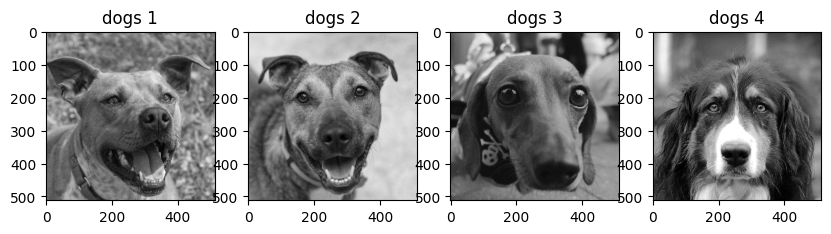

cats examples:


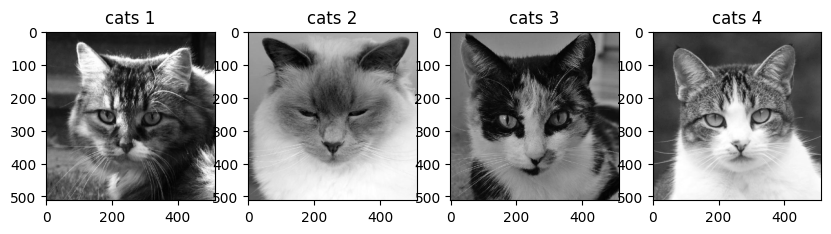

In [25]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

images_directory = "./images/train"
image_categories = ["dogs", "cats"]
n_examples = 4


def load_images_from_category(category):
    gray_images = [
        rgb2gray(img)
        for img in ski.io.imread_collection(images_directory + f"/{category}/*.jpg")
    ]
    gray_images_uint8 = [ski.util.img_as_ubyte(img) for img in gray_images]
    return gray_images_uint8


def load_train_images(categories):
    return {category: load_images_from_category(category) for category in categories}


train_images_by_categories = load_train_images(image_categories)

train_images_dogs = train_images_by_categories["dogs"]
train_images_cats = train_images_by_categories["cats"]


def show_gray_scale_image_examples(images, n=3, label="Example"):
    imgs = images[0:n]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(f"{label} {i+1}")
        plt.axis("on")


def show_examples_by_category(categories, images, n=3):
    for category in categories:
        print(f"{category} examples:")
        show_gray_scale_image_examples(images[category], n=n, label=category)
        plt.show()

show_examples_by_category(image_categories, train_images_by_categories, n=n_examples)


Mostra o histograma das imagens de exemplo:

dogs histograms:


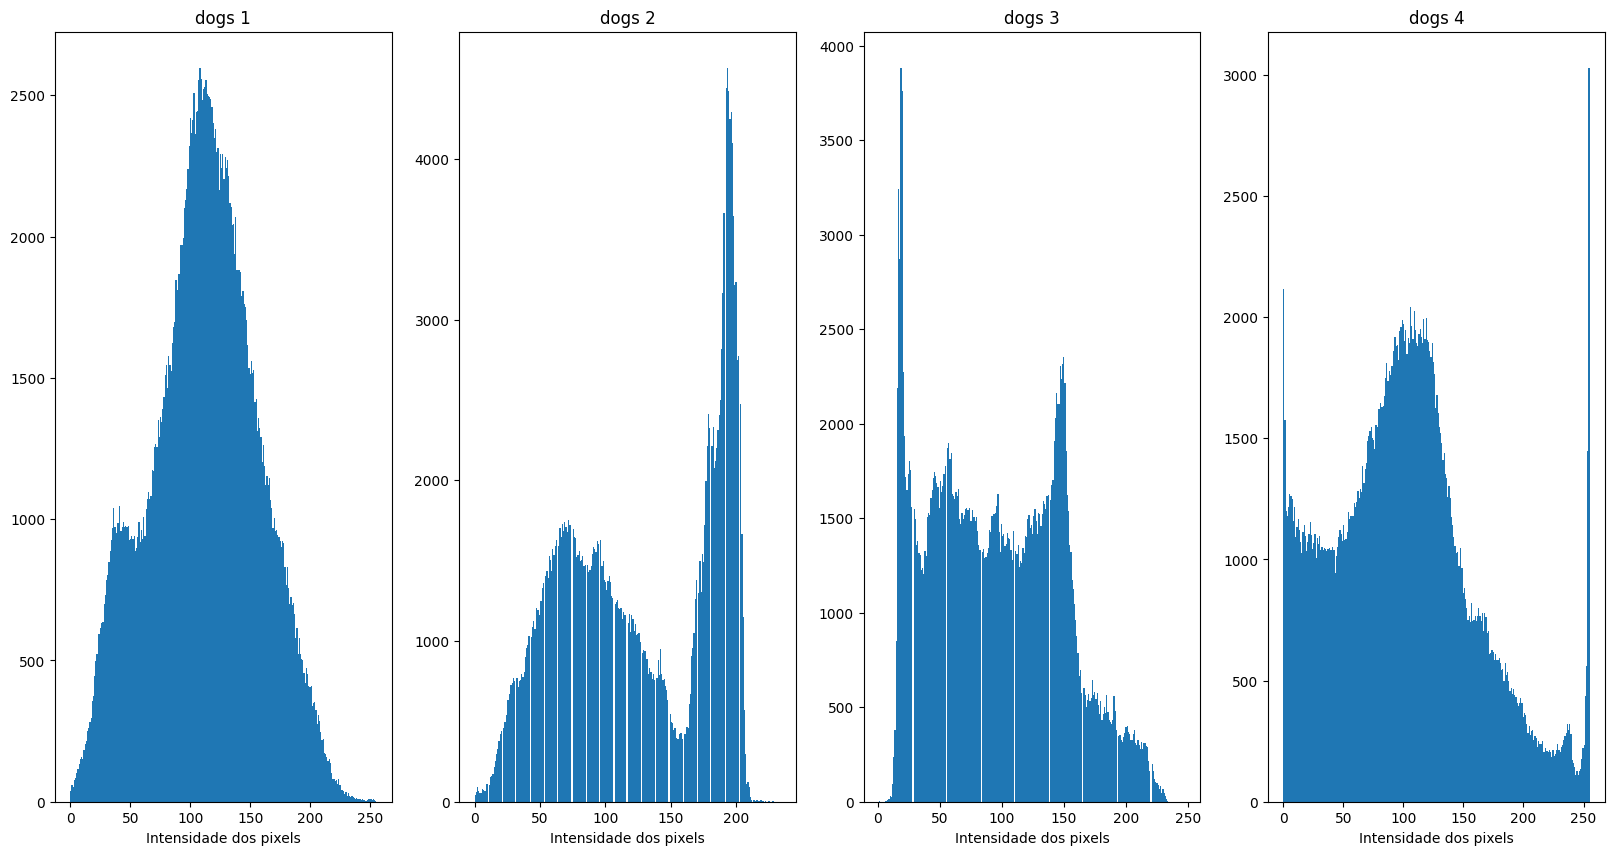

cats histograms:


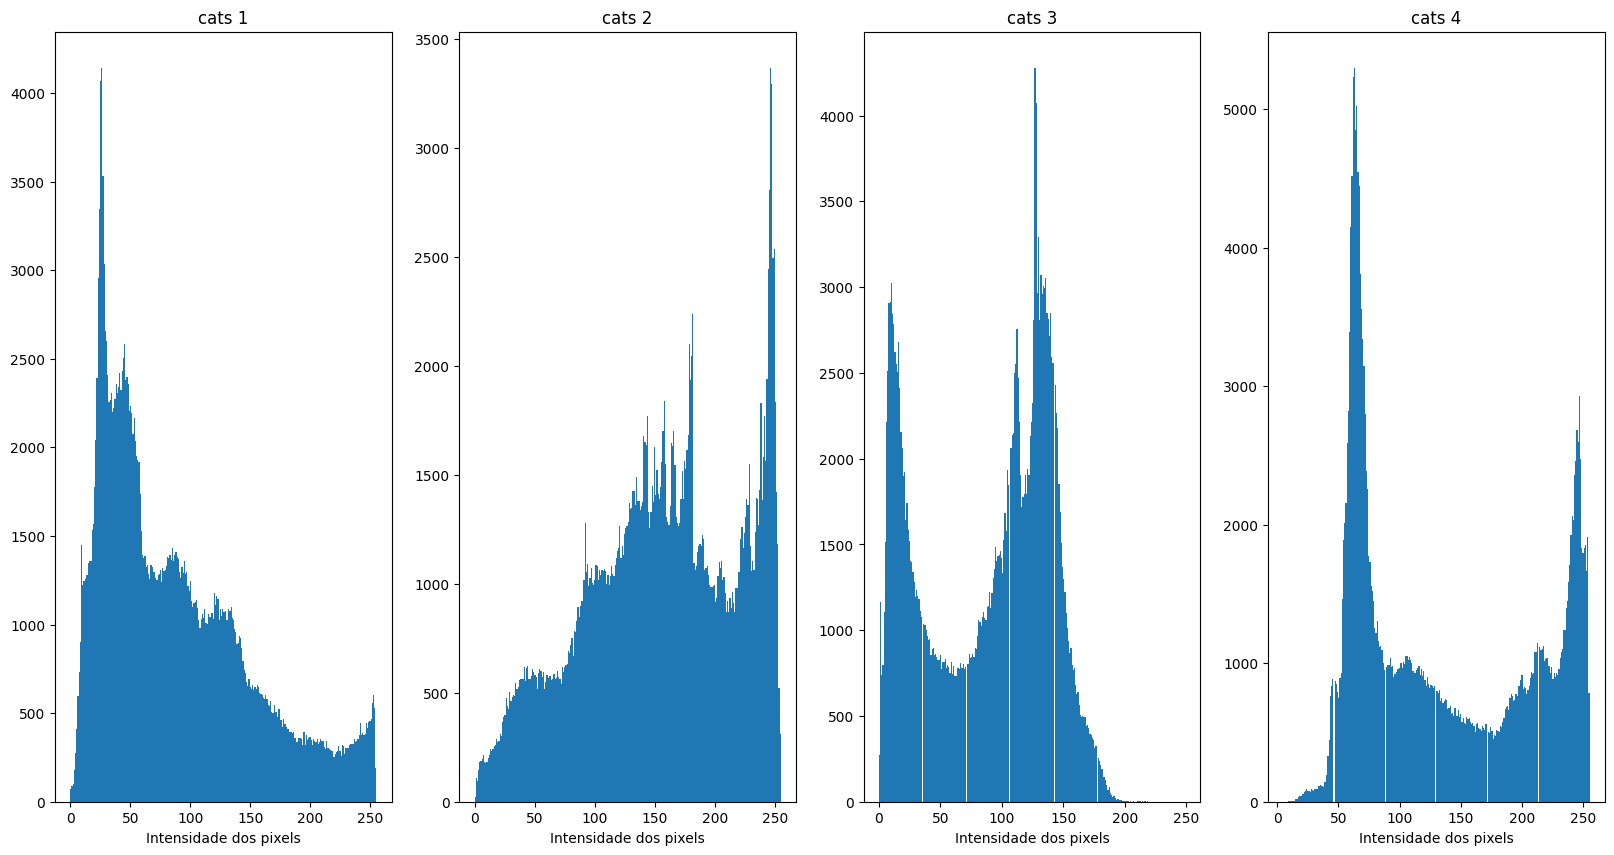

In [26]:
def show_examples_histograms(images, n=3, label="Example"):
    imgs = images[0:n]
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.hist(img.ravel(), bins=256)
        plt.title(f"{label} {i+1}")
        plt.axis("on")
        plt.xlabel("Intensidade dos pixels")


def show_examples_histograms_by_category(categories, images, n=3):
    for category in categories:
        print(f"{category} histograms:")
        show_examples_histograms(images[category], n=n, label=category)
        plt.show()


show_examples_histograms_by_category(
    image_categories, train_images_by_categories, n=n_examples
)

## Extrair a estrutura das imagens de treino com LBP

Cada imagem tem sua própria estrutura. Todavia, imagens de objetos similares, via de regra, terão certa semelhança entre suas estruturas. Imagens de gatos terão uma "textura" similar entre si, supostamente. O que não é esperado ocorrer entre uma imagem de um gato e um cachorro, por exemplo.  

Nesse contexto, é possível utilizar o algoritmo **LBP (Local Binary Pattern)** para extrair a estrutura/textura das imagens de treino e agrupá-las em categorias.

In [27]:

# settings for LBP
radius = 2
n_pixels = 8

def compute_lbp_for_single_image(image, radius, n_points, method='nri_uniform'):
    return local_binary_pattern(image, n_points, radius, method)

def compute_lbp_for_many_images(images, radius, n_points, method='nri_uniform'):
    return [compute_lbp_for_single_image(img, radius, n_points, method) for img in images]

def compute_lbp_for_each_category(categories, categories_images, radius=2, n_points=8, method='nri_uniform'):
    return {category: compute_lbp_for_many_images(categories_images[category], radius, n_points, method) for category in categories}

lbps_dogs = compute_lbp_for_many_images(train_images_dogs, radius, n_pixels)
lbps_cats = compute_lbp_for_many_images(train_images_cats, radius, n_pixels)
lbps_dict_categories = compute_lbp_for_each_category(image_categories, train_images_by_categories, radius, n_pixels)


Para visualizar a estrutura computada das imagens pode-se montar um histograma com as informações fornececidas pelo LBP.

Identified 59 characteristics for dogs
dogs histograms:


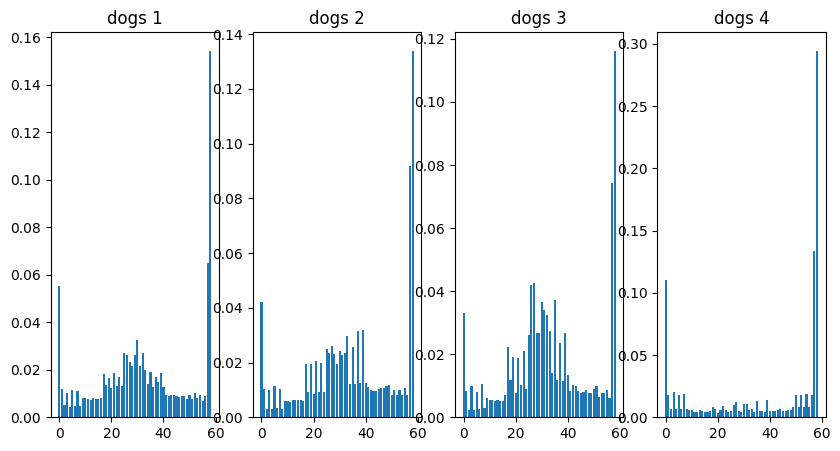

Identified 59 characteristics for cats
cats histograms:


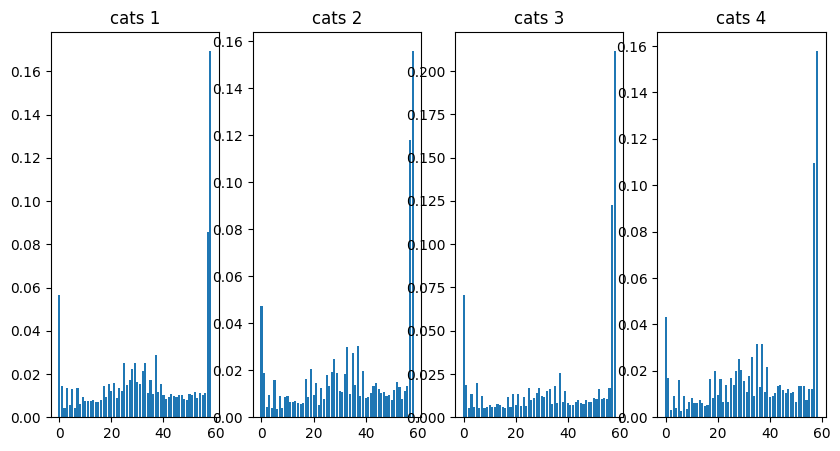

In [28]:
def build_histogram_from_lbp(lbp, n_pixels):
    n_bins = int(lbp.max() + 1)
    histogram, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))

    # normalize the histogram
    histogram = histogram.astype("float")
    histogram /= histogram.sum() + 1e-6

    return histogram


def build_histogram_from_many_lbps(lbps, n_pixels):
    return [build_histogram_from_lbp(lbp, n_pixels) for lbp in lbps]


def build_histograms_from_categories(categories, lbps, n_pixels):
    return {
        category: build_histogram_from_many_lbps(lbps[category], n_pixels)
        for category in categories
    }


lbps_histograms_by_categories = build_histograms_from_categories(
    image_categories, lbps_dict_categories, n_pixels
)


def show_sample_histograms(histograms, n=3, label="Example"):
    vals = range(len(histograms[0]))
    plt.figure(figsize=(10, 5))

    for i, sample in enumerate(histograms[0:n]):
        plt.subplot(1, n, i + 1)
        plt.bar(vals, sample)
        plt.title(f"{label} {i+1}")
        plt.axis("on")


def show_sample_histograms_by_category(categories, lbps_dict_histograms, n=3):

    for category in categories:
        print(f'Identified {lbps_dict_histograms[category][0].shape[0]} characteristics for {category}')
        print(f"{category} histograms:")
        show_sample_histograms(lbps_dict_histograms[category], n=n, label=category)
        plt.show()

show_sample_histograms_by_category(
    image_categories, lbps_histograms_by_categories, n=n_examples
)

## Extrair características utilizando o GLCM

Outro algoritmo muito bom para extrair características de imagens em escala de cinza é o GLCM (Gray-Level Co-Ocurrence Matrix).  
Esse algoritmo conta com algumas técnicas de extração de texturas, que podem ser utilizadas para extrair características da imagem. Algumas delas são: Contraste, Correlação, Energia e Homogeneidade. 


### Calcular matriz GLCM

O primeiro passo do algoritmo GLCM é montar a matriz de níveis de cinza, onde o número de linhas e colunas é igual ao número de níveis de cinza.

In [29]:
def calculate_glcm_from_single_image(
    image, distances, angles, levels, symmetric=True, normed=True
):
    return graycomatrix(
        image, distances, angles, levels, symmetric=symmetric, normed=normed
    )


def calculate_glcm_from_many_images(
    images, distances, angles, levels, symmetric=True, normed=True
):
    return [
        calculate_glcm_from_single_image(
            img, distances, angles, levels, symmetric, normed
        )
        for img in images
    ]


def calculate_glcm_matrix_for_each_category(
    categories, images, distances, angles, levels, symmetric=True, normed=True
):
    return {
        category: calculate_glcm_from_many_images(
            images[category], distances, angles, levels, symmetric, normed
        )
        for category in categories
    }


distances = [1, 3, 5]
angles = np.deg2rad([0, 90, 180, 270])
levels = None

glcm_list = calculate_glcm_from_many_images(
    train_images_dogs, distances, angles, levels
)

glcms_by_category = calculate_glcm_matrix_for_each_category(
    image_categories, train_images_by_categories, distances, angles, levels
)


### Extrair texturas das matrizes

Após computar as matrizes de nível de cinza, o próximo passo é extrair as características/texturas dessas matrizes, utilizando algumas das técnicas disponíveis: "contrast",    "dissimilarity", "homogeneity", "ASM","energy","correlation".

In [30]:
def extract_glcm_features(glcm, props):
    return np.array([graycoprops(glcm, prop).flatten() for prop in props]).flatten()


def extract_glcm_features_from_many_images(glcm_list, props):
    return [extract_glcm_features(glcm, props) for glcm in glcm_list]


def extract_glcm_features_for_each_category(categories, glcm_list, props):
    return {
        category: extract_glcm_features_from_many_images(glcm_list[category], props)
        for category in categories
    }


glcm_features = [
    "contrast",
    "dissimilarity",
    "homogeneity",
    "ASM",
    "energy",
    "correlation",
]

glcm_features_by_category = extract_glcm_features_for_each_category(
    image_categories, glcms_by_category, glcm_features
)

Em média são extraídas 72 características de cada imagem, utilizando a configuração escolhida aqui.

Abaixo serão exibidas as características da primeira imagem de cada classe de treino para comparação:

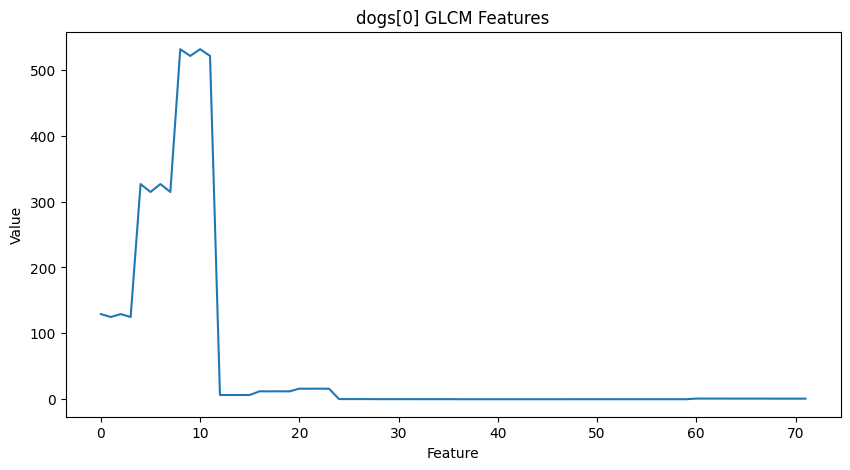

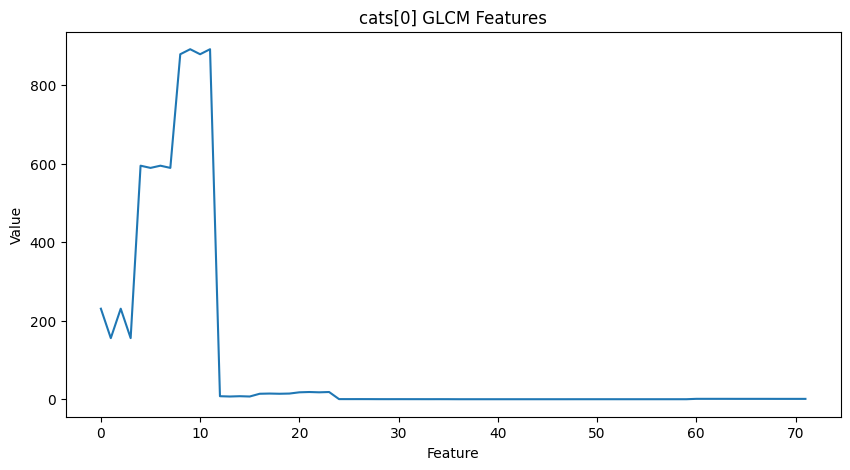

In [31]:


def show_glcm_features_for_each_category(categories, glcms):
    for category in categories:
        glcm = glcms[category][0]

        plt.figure(figsize=(10, 5))
        plt.plot(glcm)
        plt.title(f"{category}[0] GLCM Features")
        plt.xlabel("Feature")
        plt.ylabel("Value")
    plt.show()


show_glcm_features_for_each_category(image_categories, glcm_features_by_category)

# Matriz de Características

Dicionários são pouco práticos para se armazenar informações que serão utilizadas para treinar modelos de Aprendizado de Máquina. Nesse contexto, vetores e matrizes são muito mais amplamente utilizados. 
Assim, dado um vetor de `N` rótulos, por exemplo, `images_categories`, é possível imaginar a seguinte estrutura:
- Um vetor de `N` posições: `images`.
    - Cada posição do vetor corresponde ao rótulo na mesma posição em `images_categories`.
- Cada posição contém um array de duas posições:
    - A primeira posição contém as matriz de características extraídas usando o `LBP`
    - A segunda posição contém a matriz de características extraídas usando o `GLCM`
    - A terceira posição contém um vetor de rótulos.
- Cada coluna da matriz é uma característica.
- Cada linha da matriz corresponde a uma imagem.


In [32]:
def obtain_features_matrix_from_category(label, lbp_dictionary):
    matrix = lbp_dictionary[label]
    return np.array(matrix)

def generate_images_data(labels, lbp_dict, glcm_dict):
    data = []
    for l, label in enumerate(labels):
        lbp_matrix = obtain_features_matrix_from_category(label, lbp_dict)
        glcm_matrix = obtain_features_matrix_from_category(label, glcm_dict)

        (n, _) = lbp_matrix.shape
        rotulos = [l] * n;
        data.append([lbp_matrix, glcm_matrix, rotulos])
    return data

data = generate_images_data(image_categories, lbps_histograms_by_categories, glcm_features_by_category)

Ao final do processo, é esperado que para cada imagem sejam identificadas 59 características utilizando o LBP e 72 utilizando o GLCM.
Uma função que quantifica e resume as informações das imagens de entrada existe abaixo.

In [33]:
def show_data_resume(data):
    print("===Resumo dos Dados===")
    print(f"Foram lidas {len(data)} categorias:")
    for i, [lbp, glcm, _] in enumerate(data):
        print(f"Para a categoria {image_categories[i]}:")
        
        (lcount, lfeatures) = lbp.shape

        print(f"  - LBP: {lcount} exemplos com {lfeatures} características cada.")

        (gcount, gfeatures) = glcm.shape
        print(f"  - GLCM: {gcount} exemplos com {gfeatures} características cada.")
    print("=======================")

show_data_resume(data)

===Resumo dos Dados===
Foram lidas 2 categorias:
Para a categoria dogs:
  - LBP: 25 exemplos com 59 características cada.
  - GLCM: 25 exemplos com 72 características cada.
Para a categoria cats:
  - LBP: 25 exemplos com 59 características cada.
  - GLCM: 25 exemplos com 72 características cada.


Inicialmente, é interessante realizar o treino com todas as imagens juntas, sem separar por categoria. 
Nesse contexto será gerada a seguinte estrutura:
- Um vetor de 3 posições.
    - **Primeira posição:** Matriz de características LBP para todas as imagens
    - **Segunda posição:** Matriz de características GLCM para todas as imagens
    - **Terceira posição:** Rótulos referente a cada imagem.

In [34]:
def merge_data(data):
    # Extrai as matrizes e labels da primeira categoria
    [merge_lblp, merge_glcm, merge_labels] = data[0]

    # Mescla os dados das demais categorias
    for [lbp, glcm, labels] in data[1:]:
        merge_lblp = np.vstack((merge_lblp, lbp))
        merge_glcm = np.vstack((merge_glcm, glcm))
        merge_labels = np.concatenate((merge_labels, labels))

    return [merge_lblp, merge_glcm, merge_labels]

def show_merged_data(data):
    [lbp, glcm, labels] = data

    print("===Resumo dos Dados Mesclados===")
    (n,) = labels.shape
    print(f"Foram lidas {n} imagens:")
    (lcount, lfeatures) = lbp.shape

    print(f"  - LBP: {lcount} exemplos com {lfeatures} características cada.")

    (gcount, gfeatures) = glcm.shape
    print(f"  - GLCM: {gcount} exemplos com {gfeatures} características cada.")
    print("=======================")

merged_data = merge_data(data)
show_merged_data(merged_data)

===Resumo dos Dados Mesclados===
Foram lidas 50 imagens:
  - LBP: 50 exemplos com 59 características cada.
  - GLCM: 50 exemplos com 72 características cada.


# Dividir o conjunto de dados

Para esse projeto, o conjunto de dados será dividido da seguinte forma:

- 80% conjunto de treinamento, onde:
    - 80% será utilizado efetivamente para treino
    - 20% será utilizado como conjunto de validação para otimizar parâmetros
- 20% conjunto de testes

A ideia, é que hajam três modelos, cada um treinado com um tipo de conjunto de dados:
- LBP
- GLCM
- LBP + GLCM

Para facilitar o armazenamento, cada conjunto será um vetor com as seguintes características:
- Primeira posição será o conjunto de treino: Tupla com os dados de treino e os rótulos.
- Segunda posição será o conjunto de validação: Tupla com os dados de treino e os rótulos.
- Terceira: Conjunto de testes.


In [35]:
# Importa bilbliotecas que serão necessárias para dividir e padronizar dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
# Extraí os conjuntos e os labels da estrutura de dados:
[X_lbp, X_glcm, y] = merged_data

def split_data(X, y, test_size=0.2, validation_size=0.2):
    # Divide dos dados em conjunto de treino e teste
    RAND_STATE_1 = 99 # Garante que a divisão seja sempre a mesma
    RAND_STATE_2 = 101 # Garante que a divisão seja sempre a mesma

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_STATE_1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=RAND_STATE_2)

    # Padronizar a escala
    ss = StandardScaler()

    # Calcula as estatísticas para a padronização com base nos dados de treinamento
    X_train = ss.fit_transform(X_train)

    # Aplicar a padronização para os demais conjuntos
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)

    train = (X_train, y_train)
    val = (X_val, y_val)
    test = (X_test, y_test)
    return [train, val, test]
    
set_lbp = split_data(X_lbp, y)
set_glcm = split_data(X_glcm, y)

# Modelo KNN

Um dos algoritmos supervisionados mais simples é o KNN (K-Nearest Neighbor), K Vizinhos mais Próximos em tradução livre.
Ele parte da ideia de que dados que pertencem a um mesmo conjunto estarão próximos entre si, então, é seguro presumir que um novo dado pertencerá ao conjunto com mais elementos similares na região.  
Basicamente é o ditado: `"Diga-me com quem andas e te direi quem és."`.  

Partindo para uma explicação mais técnica, o `k` é um raio que define a zona de busca a ser considerada em torno do novo elemento.  
Dado esse novo elemento, será computada a distância entre o novo registro e cada ponto do conjunto, registrando-as num vetor de distância e relacionando-as com o label correspondente.
Depois, esse vetor será ordenado, tendo com base as distâncias. Indo dos mais próximos para os mais distantes.
Após a ordenação, será utilizado valor de `k` para selecionar os `k` primeiros elementos do vetor, fazendo o cálculo de frequência para cada categoria.
A categoria com maior frequência será a escolhida como categoria do novo elemento.

## Sobre o valor de K
- Se `k` for muito pequeno (`k=1`), a classificação pode ser sensível a ruídos.
- Se `k` for muito grande, podem ser incluídos elementos de outras classes.
- `k` ímpares garantem que não haverá empates.

## Sobre o cálculo de distâncias
É possível mudar a fórmula do cálculo da distância, pois dependendo do conjunto de dados, certas fórmulas se saem melhores do que outras. Alguns exemplos:
- Euclidiana
- Manhattan
- City Block



In [37]:
# Importa as bibliotecas do KNN
from sklearn.neighbors import KNeighborsClassifier

# Importa libs úteis para avaliação dos modelos
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

Uma boa predição depende dos parâmetros utilizados, nesse sentido, é desejado utilizar sempre os melhores parâmetros para se obter o melhor resultado possível. É para descobrir quais são esses parâmetros que serve o conjunto de validação.

In [39]:
K_ARRAY = [1, 3, 5, 7, 9]
DISTANCE_METRICS = ["euclidean", "manhattan", "minkowski"]

def tune_knn(k_array, distance_metrics, train, val, logs=False):
    (X_train, y_train) = train
    (X_val, y_val) = val

    # Lista com as combinações de hiperparâmetros
    parameters = []

    # Lista com as acurácias de todas as combinações de hiperparâmetros avaliadas
    # No conjunto de validação
    val_accuracy = []

    # Obtém todas as combinações possíveis de parâmetros
    for k in k_array:
        for dm in distance_metrics:
            # Salva a combinaçãoa atual de parâmetros na lista
            parameters.append((k, dm))

            # Treina um KNN com a combinação atual de parâmetros
            knn = KNeighborsClassifier(n_neighbors=k, metric=dm)
            knn.fit(X_train, y_train)

            # Realiza a predição do conjunto de validação
            prediction_val = knn.predict(X_val)

            # Calcula a acurácia do conjunto de validação
            accuracy_val = accuracy_score(y_val, prediction_val)
            val_accuracy.append(accuracy_val) # Salva a acurácia na lista de resultados

            if logs:
                print("Combinação %s: %.2f" % (parameters[-1], val_accuracy[-1]))

    # Encontra o index com a melhor acurácia
    greater_accuracy_index = np.argmax(val_accuracy)
    # Obtém os parâmetros com a melhor acurácia
    best_parameters = parameters[greater_accuracy_index]

    best_k, best_dm = best_parameters

    if logs:
        print(f"Melhor combinação de parâmetros: K={best_k}, métrica={best_dm}")

    # Mescla os conjuntos de teste e validação
    X_train = np.vstack((X_train, X_val))
    y_train = np.concatenate((y_train, y_val))

    knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_dm)

    return knn, (X_train, y_train), best_parameters

print("Otimizando Conjunto LBP:")
tuned_knn_lbp = tune_knn(K_ARRAY, DISTANCE_METRICS, set_lbp[0], set_lbp[1], logs=True)

print("\nOtimizando Conjunto GLCM:")
tuned_knn_glcm = tune_knn(K_ARRAY, DISTANCE_METRICS, set_glcm[0], set_glcm[1], logs=True)

Otimizando Conjunto LBP:
Combinação (1, 'euclidean'): 0.75
Combinação (1, 'manhattan'): 0.75
Combinação (1, 'minkowski'): 0.75
Combinação (3, 'euclidean'): 0.75
Combinação (3, 'manhattan'): 0.88
Combinação (3, 'minkowski'): 0.75
Combinação (5, 'euclidean'): 0.88
Combinação (5, 'manhattan'): 0.88
Combinação (5, 'minkowski'): 0.88
Combinação (7, 'euclidean'): 0.88
Combinação (7, 'manhattan'): 0.88
Combinação (7, 'minkowski'): 0.88
Combinação (9, 'euclidean'): 0.75
Combinação (9, 'manhattan'): 0.75
Combinação (9, 'minkowski'): 0.75
Melhor combinação de parâmetros: K=3, métrica=manhattan

Otimizando Conjunto GLCM:
Combinação (1, 'euclidean'): 0.62
Combinação (1, 'manhattan'): 0.62
Combinação (1, 'minkowski'): 0.62
Combinação (3, 'euclidean'): 0.50
Combinação (3, 'manhattan'): 0.62
Combinação (3, 'minkowski'): 0.50
Combinação (5, 'euclidean'): 0.62
Combinação (5, 'manhattan'): 0.50
Combinação (5, 'minkowski'): 0.62
Combinação (7, 'euclidean'): 0.38
Combinação (7, 'manhattan'): 0.38
Combinaç